<a href="https://colab.research.google.com/github/williamniemiec/ml-car-evaluation/blob/master/ml-car-evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autores
- Marcellus Farias
- Renan Magagnin
- William Niemiec

• Escolher um conjunto de dados e uma pergunta de pesquisa associada, com foco em problema
de classificação (binária ou multiclasse). Como sugestão, alguns repositórios que podem ser
buscados: PMLB2
, Kaggle3
e UCI ML Repository4
. Recomenda-se observar o número de
exemplos (i.e., instâncias) por classe, especialmente a classe minoritária, e evitar conjuntos de
dados que possuam menos de 10 instâncias por classe.

In [ ]:
import pandas as pd
import numpy as np
import io
import requests

# https://archive.ics.uci.edu/ml/datasets/Car+Evaluation
# car.data

url="https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')))
data.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

y = data.iloc[:,-1].values
X = data[list(data.columns.values)[:-1]]

display(data)
print('X: ', X)
print('y: ', y)

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc
...,...,...,...,...,...,...,...
1722,low,low,5more,more,med,med,good
1723,low,low,5more,more,med,high,vgood
1724,low,low,5more,more,big,low,unacc
1725,low,low,5more,more,big,med,good


X:       buying  maint  doors persons lug_boot safety
0     vhigh  vhigh      2       2    small    med
1     vhigh  vhigh      2       2    small   high
2     vhigh  vhigh      2       2      med    low
3     vhigh  vhigh      2       2      med    med
4     vhigh  vhigh      2       2      med   high
...     ...    ...    ...     ...      ...    ...
1722    low    low  5more    more      med    med
1723    low    low  5more    more      med   high
1724    low    low  5more    more      big    low
1725    low    low  5more    more      big    med
1726    low    low  5more    more      big   high

[1727 rows x 6 columns]
y:  ['unacc' 'unacc' 'unacc' ... 'unacc' 'good' 'vgood']


Avaliar a necessidade de pré-processar os dados, como por exemplo, normalizar atributos,
realizar imputação de valores, remover atributos ou instâncias com muitos valores faltantes,
dentre outros. A necessidade pode ser decorrente das características originais dos dados (isto
é, conforme disponibilizados pelo repositório) ou por especificidades dos algoritmos de aprendizado supervisionado escolhidos (ver abaixo).

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encoder = ColumnTransformer(transformers=[
  ('OneHot', OneHotEncoder(), [0,1,2,3,4,5])                 
], remainder='passthrough')
encoder_result = encoder.fit_transform(X)

X = pd.DataFrame(encoder_result.toarray())

• Selecionar ao menos três algoritmos de aprendizado supervisionado cobertos pelo conteúdo
programático da disciplina para treinamento de modelos preditivos voltados para a pergunta
de interesse. Os grupos podem optar por outros algoritmos que não sejam vistos na disciplina
em adição a estes. Os algoritmos de aprendizado não precisam ser implementados pelos
grupos: podem ser utilizadas funções prontas disponibilizadas por pacotes ou bibliotecas em
linguagens como Python ou R.


Algoritmos selecionados:
- K-Nearest Neighbors
- Naive Bayes
- Árvore de decisão

• Realizar uma implementação própria da estratégia de k-fold cross validation, que
seja genérica o suficiente para permitir o uso de diferentes valores de k (número de folds). A
estratégia deve ser aplicada de forma estratificada, isto é, mantendo-se a proporção original
de exemplos por classe em todos os folds, independente do número de classes do problema. É aconselhável que os grupos estudem as funções prontas a serem utilizadas para treinamento
dos modelos, a fim de implementarem sua função para validação cruzada de forma compatível
com as mesmas (principalmente em relação a estruturas de dados).

In [ ]:
# Deve retornar uma lista em que, para cada k, contem um par ordenado de lista de indices de treinamento e teste
def k_fold(target, k):
    total = len(target)
    fold_size = int(total / k)
    folds = [] # Tuple list: (start_range, end_range)

    # Gera os folds
    for i in range(k-1):
        folds.append((fold_size*i, fold_size*i + fold_size))

    folds.append((fold_size*(k-1), total))

    # Generates training and testing folds
    train_test_folds = []

    for i in range(k):
        # Fold de teste será i
        start_range = folds[i][0]
        end_range = folds[i][1]

        test_index = []
        for j in range(start_range, end_range):
            test_index.append(j)

        train_index = []
        for j in range(0, start_range):
            train_index.append(j)
        for j in range(end_range, total):
            train_index.append(j)

        train_test_folds.append((train_index, test_index))
    
    return train_test_folds

In [ ]:
import copy

def cross_validation(classifier, attributes, target, k):    
    generate_classifier = lambda: copy.copy(classifier)
    metricas = {
        'acuracia': [],
        'precisao': [],
        'recall': [],
        'f1': []
    }

    for train_index, test_index in k_fold(target, k):
        predicted_y = []
        expected_y = []
        x_train, x_test = attributes.loc[train_index], attributes.loc[test_index]
        y_train, y_test = target[train_index], target[test_index]

        classifier = generate_classifier()
        classifier.fit(x_train, y_train)

        predicted_y.extend(classifier.predict(x_test))
        expected_y.extend(y_test)

        metricas_k_atual = calcula_metricas(expected_y, predicted_y)
        
        for metrica in metricas.keys():
            metricas[metrica].append(metricas_k_atual[metrica])

    return metricas

• Implementar uma função própria para gerar uma matriz de confusão, e a partir dela realizar
a quantificação das métricas de acurácia, precisão, recall e F1-measure. As métricas também
devem ser calculadas por funções criadas pelos grupos. Para problemas multiclasse, deve
ser utilizada a micro-média para sumarizar o desempenho em termos de precisão, recall e
F1-measure.

In [ ]:
from enum import Enum

class ValoresSaida(Enum):
    unacc = 0
    acc = 1
    good = 2
    vgood = 3

    def get_enum(string):
        if string == 'unacc':
            return ValoresSaida.unacc
        if string == 'acc':
            return ValoresSaida.acc
        if string == 'good':
            return ValoresSaida.good
        if string == 'vgood':
            return ValoresSaida.vgood

        raise Exception('Error enum!')


class MatrizConfusao:
    """
    Implementar uma função própria para gerar uma matriz de confusão,  e a partir
    dela realizar a quantificação das métricas de acurácia, precisão, recall e
    F1-measure
    """

    def __init__(self, y_esperado_array, y_predito_array):

        if len(y_esperado_array) != len(y_predito_array):
            raise Exception('Lists are not equal!')

        self.A = [[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]]

        self.total_itens = 0

        for i in range(len(y_esperado_array)):
            item_predito = ValoresSaida.get_enum(y_predito_array[i])
            item_esperado = ValoresSaida.get_enum(y_esperado_array[i])

            self.A[item_esperado.value][item_predito.value] = self.A[item_esperado.value][item_predito.value] + 1
            self.total_itens = self.total_itens + 1

    def __str__(self):
        try:
            return "\n" + ('\n'.join([''.join(['{:4}'.format(item) for item in row])
                                      for row in self.A]))
        except:
            return("Falha ao gerar Matriz Confusao\n")

    def get_verdadeiros_positivos(self):
        verdadeiros_positivos = 0
        for i in [0, 1, 2, 3]:
            verdadeiros_positivos = verdadeiros_positivos + self.A[i][i]

        return verdadeiros_positivos

    def get_verdadeiros_negativos(self):
        verdadeiros_negativos = 0
        lista = [0, 1, 2, 3]
        for current_class in [0, 1, 2, 3]:
            lista.remove(current_class)
            for i in lista:
                for j in lista:
                    verdadeiros_negativos = verdadeiros_negativos + \
                        self.A[i][i]
            lista.append(current_class)

        return verdadeiros_negativos

    def get_falso_positivos(self):
        falso_positivos = 0
        lista = [0, 1, 2, 3]
        for current_class in [0, 1, 2, 3]:
            lista.remove(current_class)
            for i in lista:
                falso_positivos = falso_positivos + \
                    self.A[i][current_class]
            lista.append(current_class)

        return falso_positivos

    def get_falso_negativos(self):
        falso_negativos = 0
        lista = [0, 1, 2, 3]
        for current_class in [0, 1, 2, 3]:
            lista.remove(current_class)
            for i in lista:
                falso_negativos = falso_negativos + \
                    self.A[current_class][i]
            lista.append(current_class)

        return falso_negativos

    def get_acuracia(self):
        return (self.get_verdadeiros_positivos()) / self.total_itens

    def get_precisao(self):
        return self.get_verdadeiros_positivos() / (self.get_verdadeiros_positivos() + self.get_falso_positivos())

    def get_recall(self):
        return self.get_verdadeiros_positivos() / (self.get_verdadeiros_positivos() + self.get_falso_negativos())

    def get_f1(self, B=1):
        return (1 + pow(B, 2)) * ((self.get_precisao() * self.get_recall()) / ((pow(B, 2) * self.get_precisao()) + self.get_recall()))

def calcula_metricas(y_esperado_array, y_predito_array):
    metricas = {
        'acuracia': 0.0,
        'precisao': 0.0,
        'recall': 0.0,
        'f1': 0.0,
        'matriz_confusao': ""
    }

    matriz_confusao = MatrizConfusao(y_esperado_array, y_predito_array)

    metricas['acuracia'] = matriz_confusao.get_acuracia()
    metricas['precisao'] = matriz_confusao.get_precisao()
    metricas['recall'] = matriz_confusao.get_recall()
    metricas['f1'] = matriz_confusao.get_f1()
    metricas['matriz_confusao'] = str(matriz_confusao)
    
    return metricas


• Aplicar a implementação da estratégia de k-fold cross validation e da matriz de confusão e
métricas de desempenho ao problema de classificação selecionado, avaliando de forma comparativa o desempenho dos algoritmos de aprendizado supervisionado escolhidos. Os grupos
deverão reportar, no mínimo, desempenho médio e desvio padrão obtido através do processo
de validação cruzada, discutindo os resultados de forma comparativa entre os algoritmos de
aprendizado usados. O uso de gráficos como boxplot é desejável e será valorizado na avaliação
do trabalho.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB

algorithmsByName = {
    'Naive Bayes': GaussianNB(),
    'KNN': NearestCentroid(),
    'Decision Tree': DecisionTreeClassifier(),
}

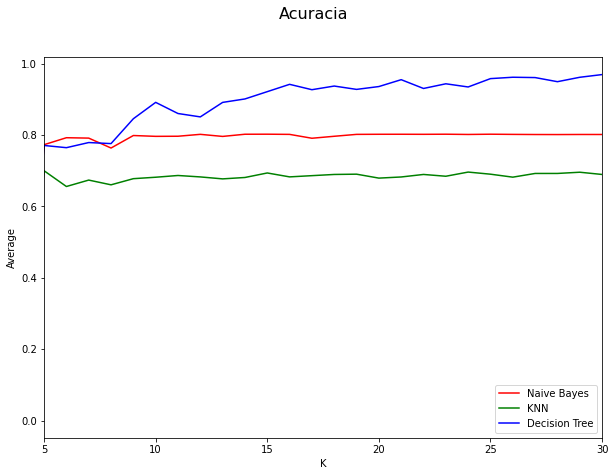

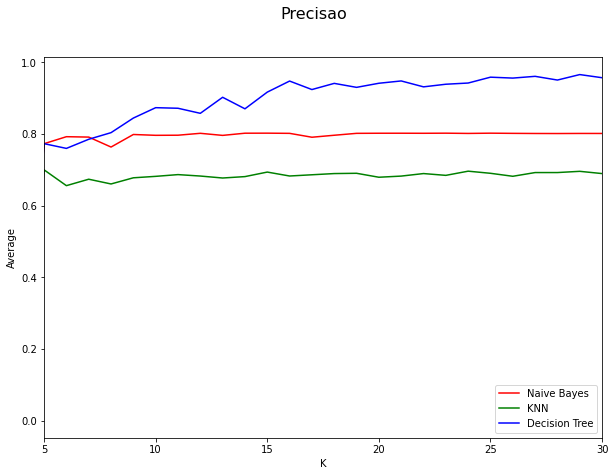

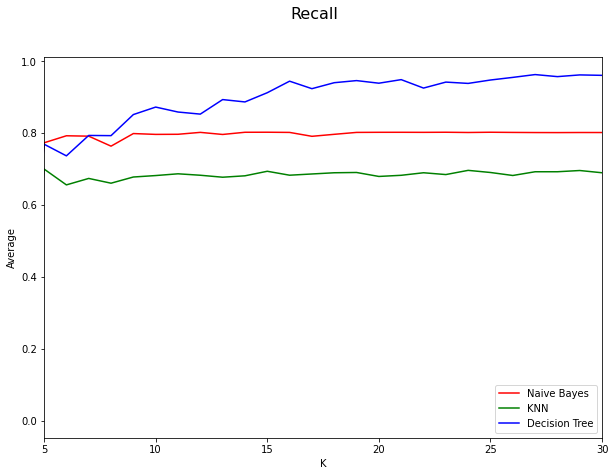

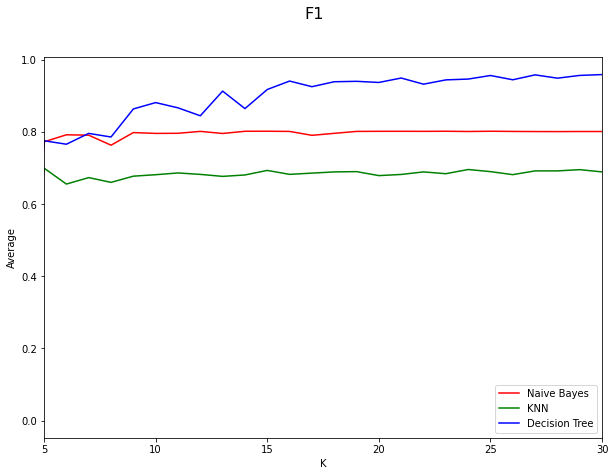

In [ ]:
import matplotlib.pyplot as plt
from statistics import mean, stdev

metrics = ['acuracia', 'precisao', 'recall', 'f1']
k_min, k_max  = 5, 30
k_range = range(k_min, k_max+1)

algorithms = list(algorithmsByName.keys())
colors = ['r-', 'g-', 'b-']

def plot_metric(metric_name):
  fig = plt.figure(figsize =(10, 7))
  plt.xlabel("K")
  plt.ylabel("Average")
  plt.xlim([k_min, k_max])
  fig.suptitle(metric.capitalize(), fontsize=16)

  for algorithm, color in zip(algorithms, colors):
      averages = [0] * (k_min)
      for k in k_range:
        crossValidationResults = cross_validation(algorithmsByName[algorithm], X, y, k)
        accuracies = crossValidationResults[metric_name]
        average = mean(accuracies)
        averages.append(average)
      plt.plot(averages, color, label=algorithm)

  plt.legend(loc='lower right')
  

for metric in metrics:
  plot_metric(metric)


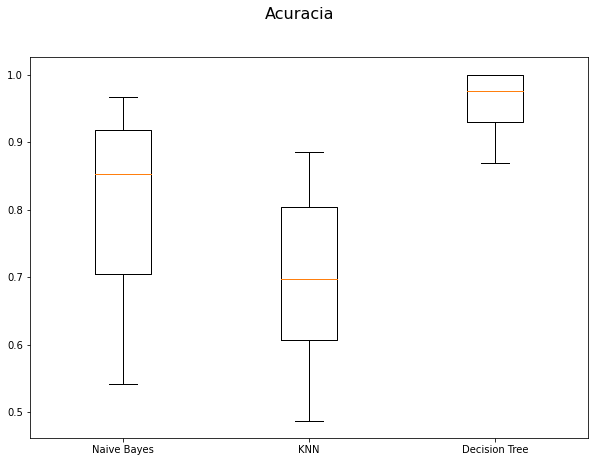

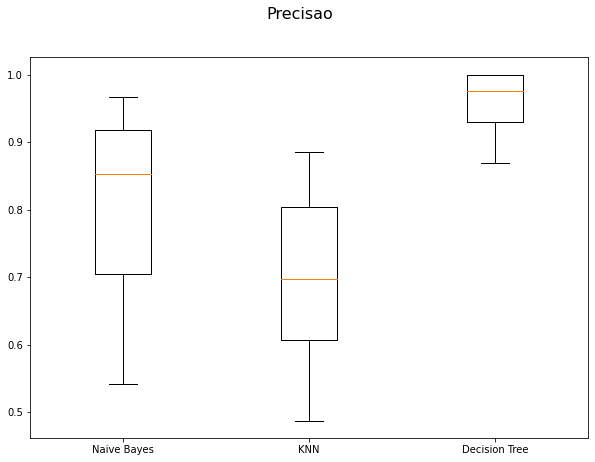

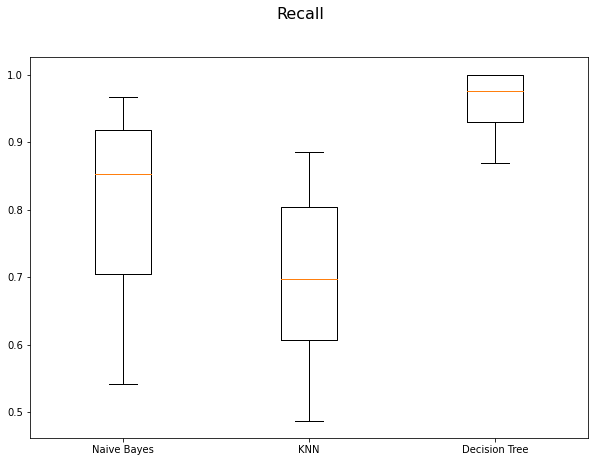

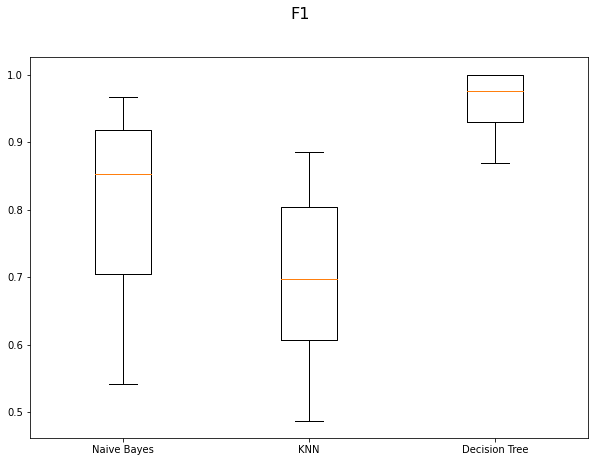

In [ ]:
k = 28 # Melhor k é 28 conforme os gráficos acima
crossValidationResults = {name: cross_validation(algorithm, X, y, k) for name, algorithm in algorithmsByName.items()}

for metric in metrics:
    fig = plt.figure(figsize =(10, 7))
    fig.suptitle(metric.capitalize(), fontsize=16)
    
    values = [crossValidationResults[algorithm][metric] for algorithm in crossValidationResults]
    plt.boxplot(values)

    algorithms = crossValidationResults.keys()
    plt.xticks(range(1, len(algorithms) + 1), crossValidationResults.keys())

plt.show()

In [ ]:
for metric in metrics:
    print('-----< ' + metric + ' >-----')
    for algorithm in crossValidationResults:
        print('# ' + algorithm)
        print('MEDIA:        ', mean(crossValidationResults[algorithm][metric]))
        print('DESVIO PADRÃO:', stdev(crossValidationResults[algorithm][metric]))
        print()

-----< acuracia >-----
# Naive Bayes
MEDIA:         0.801463700234192
DESVIO PADRÃO: 0.13331044272266943

# KNN
MEDIA:         0.692469262295082
DESVIO PADRÃO: 0.11693425991722886

# Decision Tree
MEDIA:         0.9560889929742389
DESVIO PADRÃO: 0.044629248966454406

-----< precisao >-----
# Naive Bayes
MEDIA:         0.801463700234192
DESVIO PADRÃO: 0.13331044272266943

# KNN
MEDIA:         0.692469262295082
DESVIO PADRÃO: 0.11693425991722886

# Decision Tree
MEDIA:         0.9560889929742389
DESVIO PADRÃO: 0.044629248966454406

-----< recall >-----
# Naive Bayes
MEDIA:         0.801463700234192
DESVIO PADRÃO: 0.13331044272266943

# KNN
MEDIA:         0.692469262295082
DESVIO PADRÃO: 0.11693425991722886

# Decision Tree
MEDIA:         0.9560889929742389
DESVIO PADRÃO: 0.044629248966454406

-----< f1 >-----
# Naive Bayes
MEDIA:         0.801463700234192
DESVIO PADRÃO: 0.13331044272266943

# KNN
MEDIA:         0.692469262295082
DESVIO PADRÃO: 0.11693425991722886

# Decision Tree
MEDIA: 